# 3D example
The procedure for three-dimensional design space identification is exactly the same as in the two-dimensional problem. The only difference is in the dataset and the labels, `vn`, given into `ds.find_DSp(vn)` having three system variables.

In [1]:
# Imports
from dside import DSI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The problem
The design space identification technique used here is based on point cloud analysis using alpha shapes. The input into the DSI entity is simply a pandas dataframe containing the system variables and the outputs (key performance indicators - KPIs). Here, we consider an example problem where we will be generating our input and outputs using some simple non-linear constraints.

In [2]:
# ----- Generate Inputs ----- #
def Sobol_sequence(lbd, ubd, power_no):
    """
    Create 2^power_no of inputs for sampling based on the lists
    of lbd (lower bound) and ubd (upper bound).
    """
    from scipy.stats import qmc
    sampler = qmc.Sobol(d = len(lbd), scramble = False)
    inputs = sampler.random_base2(m = power_no)
    inputs = qmc.scale(inputs, lbd, ubd)
    return inputs

# Preparing example dataset
SV1_bounds    = [0, 1]
SV2_bounds    = [0, 1]
SV3_bounds    = [0, 1]

lbd = [SV1_bounds[0], SV2_bounds[0], SV3_bounds[0]]
ubd = [SV1_bounds[1], SV2_bounds[1], SV3_bounds[1]]

# Use Sobol sequence to generate inputs
pwr = 10
inputs = Sobol_sequence(lbd, ubd, pwr)
SV1 = inputs[:, 0]
SV2 = inputs[:, 1]
SV3 = inputs[:, 2]

# ----- Create Outputs and dataframe ----- #
# Create example KPIs
KPI1 = SV1*10 + 5*SV2**4
KPI2 = SV1*10 - 5*SV2**4 + 2.5*SV3**4

d = np.array([SV1, SV2, SV3, KPI1, KPI2]).T
l = ['SV1', 'SV2', 'SV3', 'KPI1', 'KPI2']
data = pd.DataFrame(d, columns = l)
print(data.head(5))

     SV1    SV2    SV3      KPI1      KPI2
0  0.000  0.000  0.000  0.000000  0.000000
1  0.500  0.500  0.500  5.312500  4.843750
2  0.750  0.250  0.250  7.519531  7.490234
3  0.250  0.750  0.750  4.082031  1.708984
4  0.375  0.375  0.625  3.848877  4.032593


So we have created a dataframe containing the system variables: SV1, SV2, & SV3 with the outputs: KPI1 & KPI2. Let's visualize our data by creating some plots.

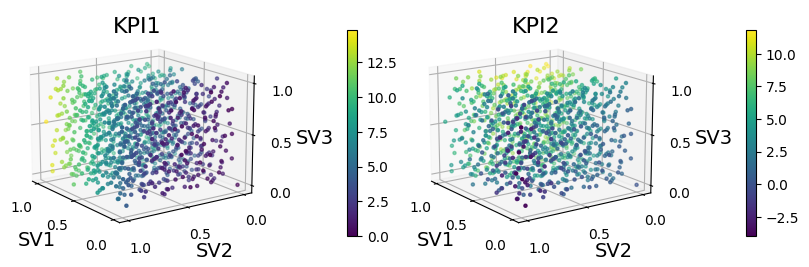

In [3]:
fs = 14
fig = plt.figure(figsize = (8, 3))
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
s1 = ax1.scatter(SV1, SV2, SV3, c = KPI1, marker = '.')
cbar1 = fig.colorbar(s1, ax = ax1, fraction = 0.03, pad = 0.25)
ax1.view_init(15, 145)
ax1.set_title('KPI1', fontsize = fs + 2, y = 0.95)
ax1.set_xlabel('SV1', fontsize = fs)
ax1.set_ylabel('SV2', fontsize = fs)
ax1.set_zlabel('SV3', fontsize = fs)
ax1.set_xticks([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1])
ax1.set_zticks([0, 0.5, 1])

ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
s2 = ax2.scatter(SV1, SV2, SV3, c = KPI2, marker = '.')
cbar2 = fig.colorbar(s2, ax = ax2, fraction = 0.03, pad = 0.25)
ax2.view_init(15, 145)
ax2.set_title('KPI2', fontsize = fs + 2, y = 0.95)
ax2.set_xlabel('SV1', fontsize = fs)
ax2.set_ylabel('SV2', fontsize = fs)
ax2.set_zlabel('SV3', fontsize = fs)
ax2.set_xticks([0, 0.5, 1])
ax2.set_yticks([0, 0.5, 1])
ax2.set_zticks([0, 0.5, 1])

plt.tight_layout()
plt.show()

## Design Space Identification
As shown from the plots, we can see clearly that the outputs are non-linear with respect to the system variables. However, the design space identification method used in the package allows for the identification of non-convex hulls using alpha shapes. So let's go ahead and identify our design space by first defining some constraints on the KPIs.

Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |         90         |     2.500e+00      
    2     |     1.250e+00      |        True        |         89         |     1.250e+00      
    3     |     6.250e-01      |        True        |         11         |     6.250e-01      
    4     |     3.125e-01      |       False        |         0          |     3.125e-01      
    5     |     4.688e-01      |        True        |         2          |     1.562e-01      
    6     |     3.906e-01      |        True        |         1          |     7.812e-02      

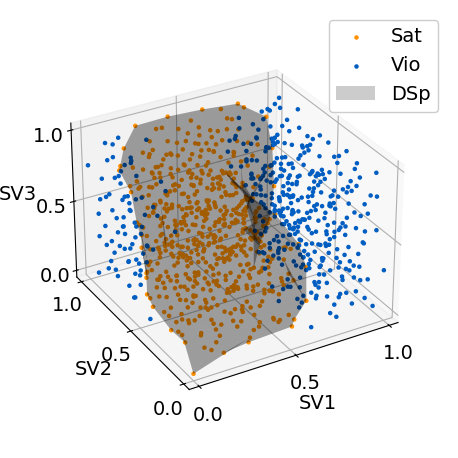

Check for violations inside design space:
Empty DataFrame
Columns: [SV1, SV2, SV3, KPI1, KPI2, SatFlag]
Index: []


In [4]:
# Define our system variable labels
vn = ['SV1', 'SV2', 'SV3']
# Define the KPI constraints as a dictionary
# the keys corresponds to the column of the dataframe
constraints = {'KPI1': [0, 20], 'KPI2': [0, 6]}

# Initialize the design space entity
ds = DSI(data)
# Apply the constraints separating the satisfied and violated points
ds.screen(constraints)
# Finding the design space (alpha shape)
ds.find_DSp(vn)
# Plot the design space
ds.plot()

# We can extract matplotlib ax and figure from the class
fig = ds.fig
ax = ds.ax
# Rotate the plot (use %matplotlib notebook in Jupyter notebook)
ax.view_init(30, -120)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_zticks([0, 0.5, 1])
plt.show()

# Check if there are any violated points in the design space
print('Check for violations inside design space:')
print(ds.vindsp)

As you can see, the alpha shapes can capture the non-convexity of the design space without any violated points inside the design space. Here, we used a bisection search to find the alpha radius value which gives no violation inside our design space. 

We can check the details of the identified design space by calling `ds.report` and also `ds.send_output()` to output a text file with the details.

In [5]:
# Print out the size of the identified design space
print('Design space size:', ds.report['space_size'])

# Output the details about the design space as a .txt file
ds.send_output('example_3D_1')

Design space size: 0.48273571404089566


## Further Analysis
We can also use the same dataset with different constraints to identify a different design space. This time, lets print out the alpha radius search iterations by giving some options.

Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |         1          |     2.500e+00      
    2     |     1.250e+00      |       False        |         0          |     1.250e+00      
    3     |     1.875e+00      |       False        |         0          |     6.250e-01      
    4     |     2.188e+00      |        True        |         1          |     3.125e-01      
    5     |     2.031e+00      |        True        |         1          |     1.562e-01      
    6     |     1.953e+00      |        True        |         1          |     7.812e-02      

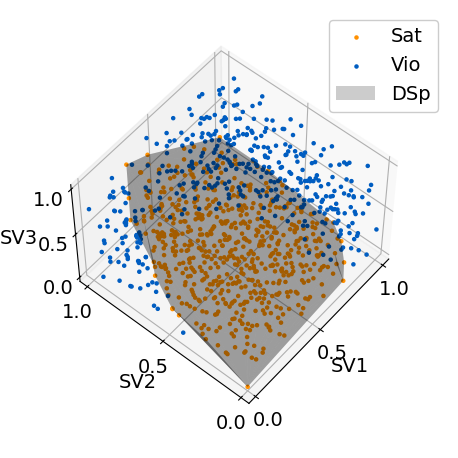

Check for violations inside design space:
Empty DataFrame
Columns: [SV1, SV2, SV3, KPI1, KPI2, SatFlag]
Index: []


In [6]:
# New constraints
constraints = {'KPI1': [0, 8], 'KPI2': [0, 8]}

# Initialize the design space entity
ds = DSI(data)
# Apply the constraints separating the satisfied and violated points
ds.screen(constraints)
# Finding the design space (alpha shape)
ds.find_DSp(vn, opt = {'printF': True})
# Plot the design space
ds.plot()

# We can extract matplotlib ax and figure from the class
fig = ds.fig
ax = ds.ax
# Rotate the plot (use %matplotlib notebook in Jupyter notebook)
ax.view_init(55, -140)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_zticks([0, 0.5, 1])
ax.set_box_aspect(None, zoom = 0.80) # adjust zoom of the plot to fix clipping of labels
plt.show()

# Check if there are any violated points in the design space
print('Check for violations inside design space:')
print(ds.vindsp)

In addition, we can identify acceptable operating regions with respect to any nominal point. Let's assume we have a nominal point of interest at `[0.4, 0.4, 0.5]`.

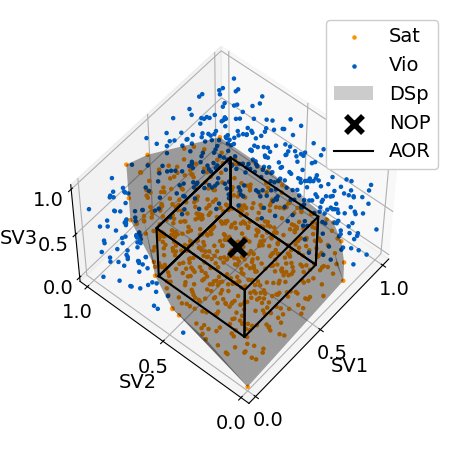

AOR size: 0.16443289909511805


In [7]:
# The find_AOR function plots the AOR boundary
# therefore if we call ds.find_AOR() after ds.plot()
# the boudary will be drawn over the design space plot.
x = [0.4, 0.4, 0.5]
ds.plot()
ds.find_AOR(x)

# We can extract matplotlib ax and figure from the class
fig = ds.fig
ax = ds.ax
# Rotate the plot (use %matplotlib notebook in Jupyter notebook)
ax.view_init(55, -140)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_zticks([0, 0.5, 1])
ax.set_box_aspect(None, zoom = 0.80) # adjust zoom of the plot to fix clipping of labels
plt.show()

# Call ds.all_x[str(x)] to access the details on the AOR
print('AOR size:', ds.all_x[str(x)]['space_size'])

# When we call ds.send_output() the details of any identified
# AOR will also be outputted in the text file.
ds.send_output('example_3D_2')

As shown, we can identify acceptable operating regions with respect to any nominal points. This allows for the quantification of acceptable ranges with respect to the nominal point. In other words, we can obtain +- value of the system variable axes where operation is guaranteed to still be inside of the design space.